In [36]:
import multiresolutionimageinterface as mir
import openslide
import numpy as np
import skimage
import matplotlib.pyplot as plt
import math
from skimage import morphology, measure,color,io, exposure
from scipy import ndimage

In [226]:
def filter_ch(rgb):
    (h, w, c) = rgb.shape
    rgb = rgb.astype(np.int)
    r_f = (rgb[:,:,0] > 47) & (rgb[:,:,0] < 130)
    g_f = (rgb[:,:,1] > 47) & (rgb[:,:,1] < 130)
    b_f = (rgb[:,:,2] > 40) & (rgb[:,:,2] < 110)
    mask = (r_f & b_f & g_f)
    mask = morphology.binary_dilation(mask, selem=morphology.disk(3))
    return ~mask

In [207]:

slide = openslide.OpenSlide('/media/steer/data1/Images/47.tif')

slide = openslide.OpenSlide('/run/user/1000/gvfs/sftp:host=192.168.1.101/home/data/ACDC/Images/72.tif')

In [208]:
thumb = slide.get_thumbnail(slide.level_dimensions[7])


In [209]:
thumb_rgb = np.asarray(thumb)

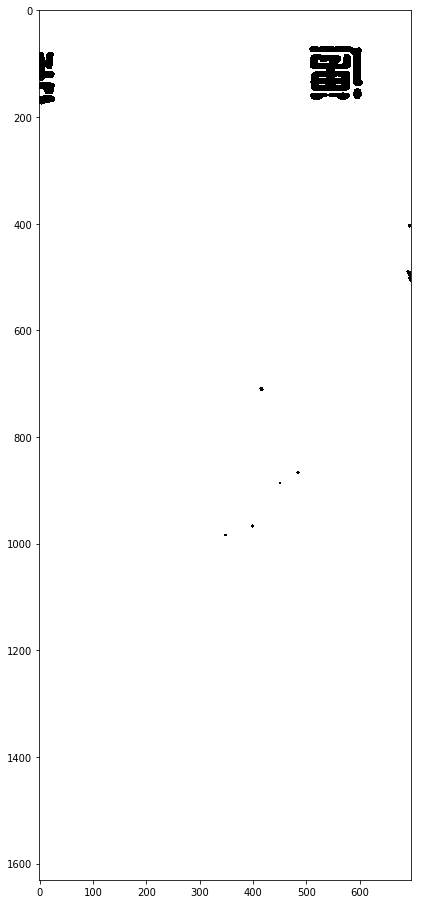

In [227]:
ret = filter_ch(thumb_rgb)
# ret = ~morphology.binary_dilation(~ret, selem=morphology.disk(3))
plt.figure(figsize=(16,16))
plt.imshow(ret, cmap = plt.cm.gray)

In [211]:
thumb_rgb.shape

(1631, 697, 3)

In [212]:
thumb_gray = skimage.color.rgb2gray(np.array(thumb))

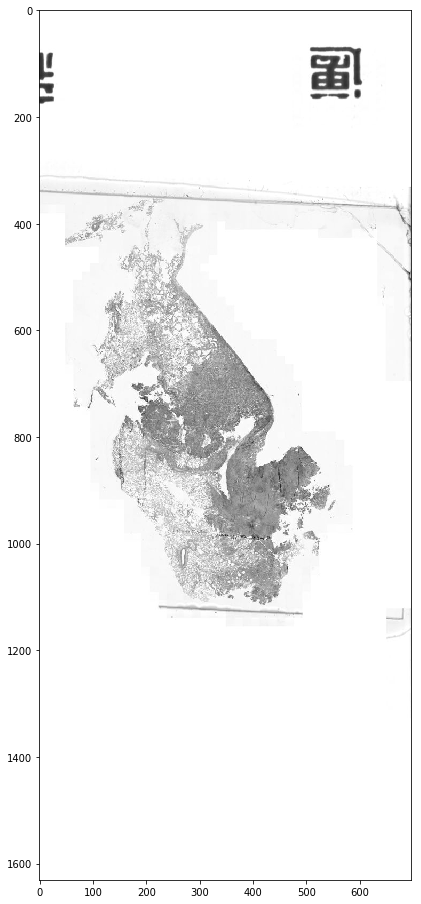

In [213]:
plt.figure(figsize=(16,16))
plt.imshow(thumb_gray, cmap=plt.cm.gray)

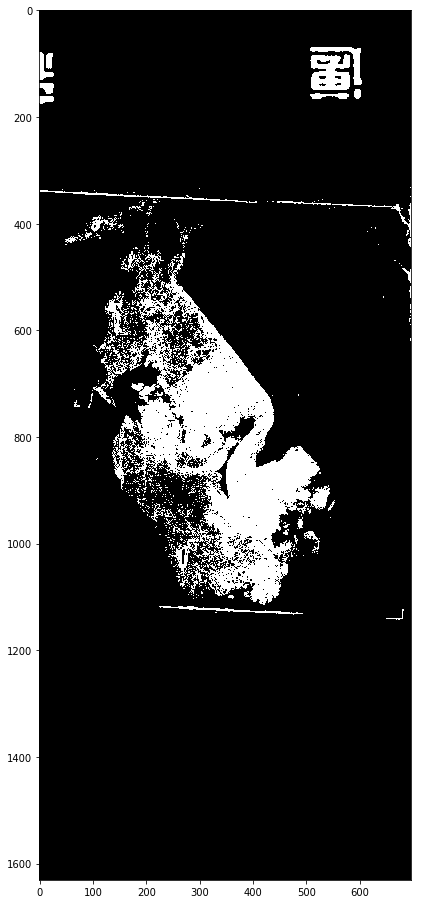

In [214]:
from skimage.filters import threshold_otsu, threshold_local
thresh = threshold_otsu(thumb_gray)
mask = thumb_gray < thresh
# mask = morphology.binary_erosion(mask, selem=morphology.rectangle(3,5))
plt.figure(figsize=(16,16))
plt.imshow(mask, cmap=plt.cm.gray)

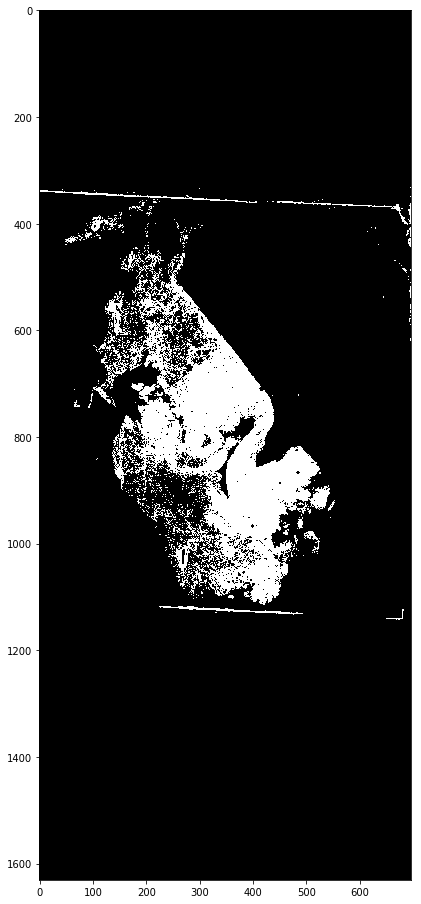

In [215]:
mask = mask&ret
plt.figure(figsize=(16,16))
plt.imshow(mask, cmap=plt.cm.gray)

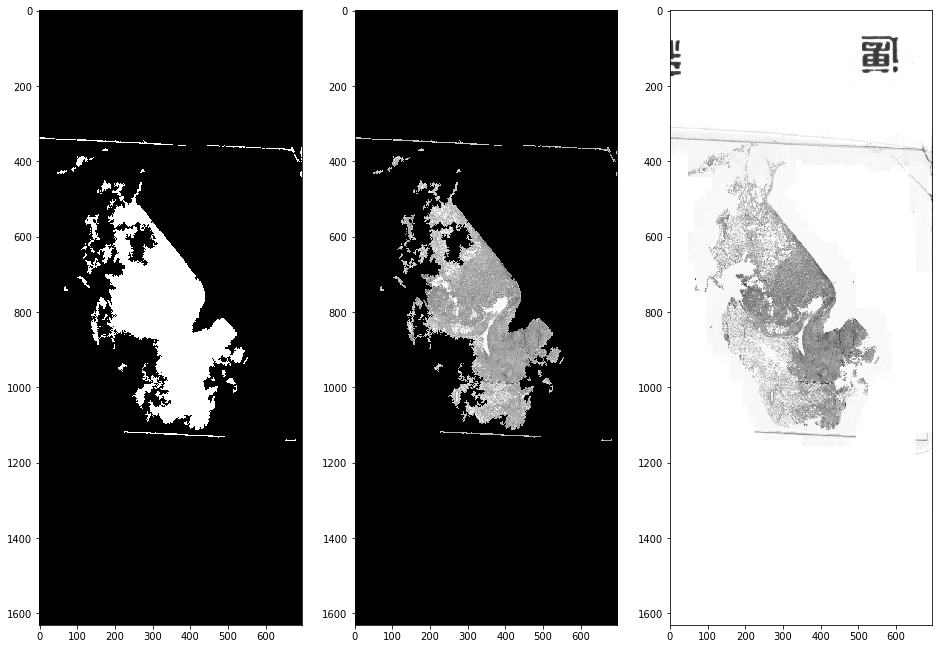

In [216]:
mask = ndimage.morphology.binary_fill_holes(mask)
mask = morphology.remove_small_objects(mask)
fg, ax = plt.subplots(1,3, figsize=(16,16))
# plt.figure(figsize=(16,16))
ax[0].imshow(mask, cmap=plt.cm.gray)
ax[1].imshow(mask*thumb_gray, cmap=plt.cm.gray)
ax[2].imshow(thumb_gray, cmap=plt.cm.gray)

In [217]:
mask_c = mask

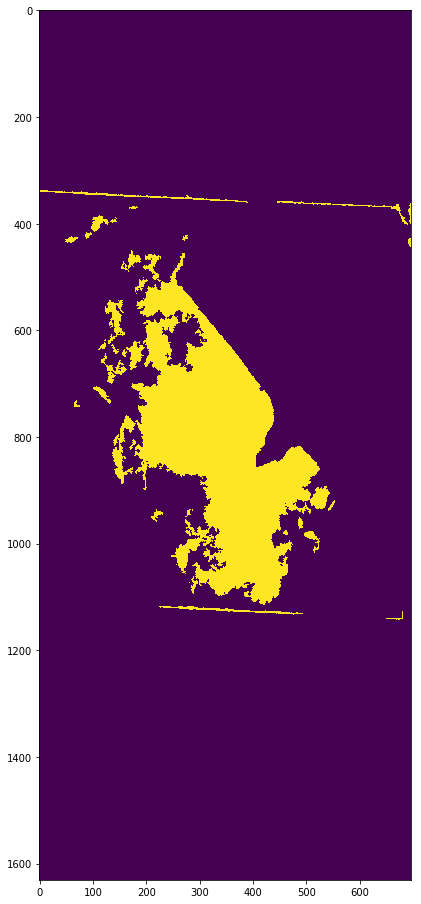

In [218]:
mask = morphology.binary_dilation(mask)
mask = morphology.binary_erosion(mask)
# convx = morphology.convex_hull_object(mask)
plt.figure(figsize=(16, 16))
plt.imshow(mask)

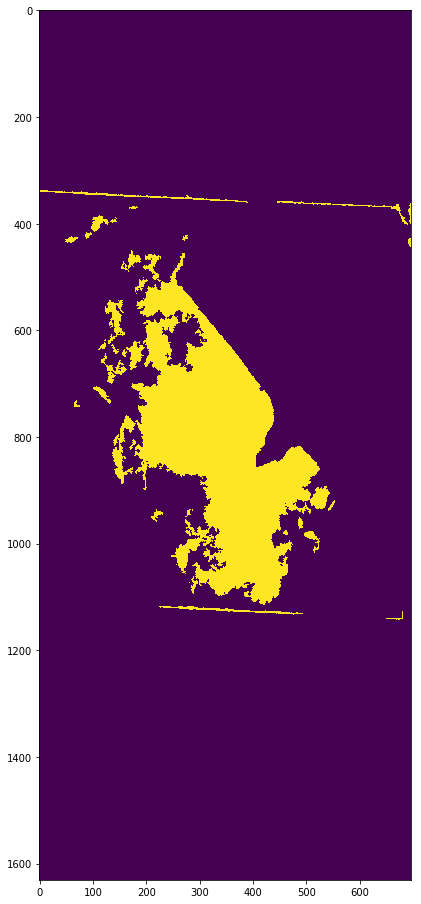

In [219]:
closed = morphology.binary_closing(mask, )
plt.figure(figsize=(16, 16))
plt.imshow(closed)

In [220]:
import matplotlib.patches as mpatches

In [221]:
thumb_gray.max(), thumb_gray.min()

(1.0, 0.16386)

In [222]:
glass_mask = thumb_gray != 1

In [223]:
label_image = measure.label(glass_mask)

In [224]:
image_label_overlay = skimage.color.label2rgb(label_image, image=glass_mask)

(64, 504, 224, 629)
(72, 0, 187, 37)
(77, 480, 96, 496)
(88, 631, 176, 652)
(101, 472, 176, 496)
(163, 624, 176, 640)
(179, 632, 192, 648)
(184, 472, 224, 496)
(280, 0, 1160, 697)
(312, 456, 328, 480)
(414, 352, 416, 432)
(1120, 648, 1333, 697)
(1248, 656, 1264, 667)
(1280, 688, 1328, 691)
(1296, 650, 1312, 664)


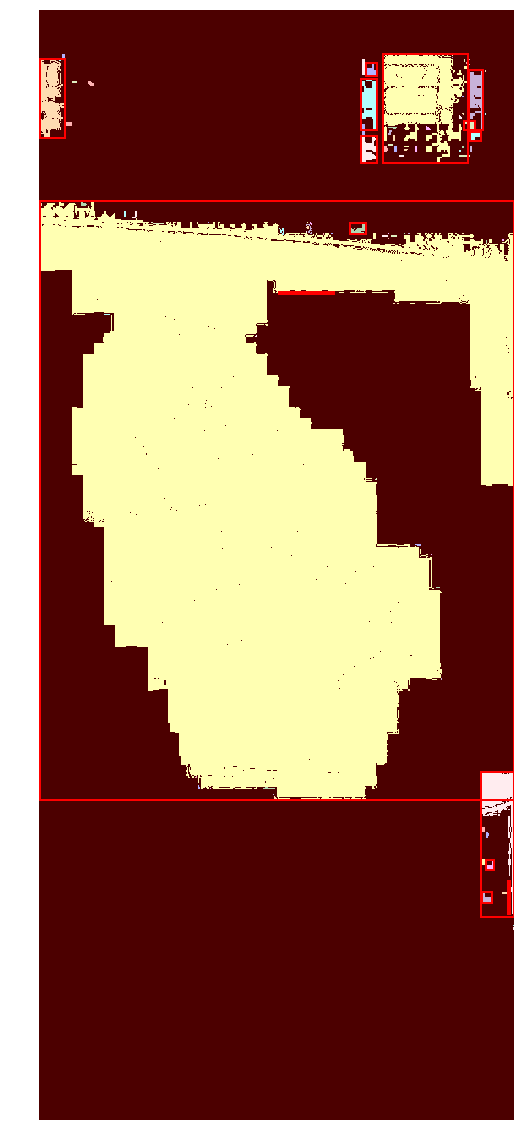

In [225]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(image_label_overlay)

for region in measure.regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        print(region.bbox)
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()